<a href="https://colab.research.google.com/github/vsnupoudel/RandomAssignments/blob/main/Descriptive_and_Inferential_analysis_of_Menstruation_Symptoms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptive and Inferential analysis of Menstruation dataset.
## Analysis Goals
- Find the most severe symptom ( numbers reported not important) 
- Find most reported Symptom ( severity not important)
- Which symptoms occur together ( correlation and co-occurance)
- Hypothesis tests to confirm if two symptoms are related ( Chi square test)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:

sheet_id = '1_fkJ3eUoBYcsoMgQ8cVJO0ofwX5g308QWOrufYLM54w'
sheet_name = 'Symptom'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

Read csv from url, parse the datetime and convert it from UTC to kathmandu time.

In [3]:
headers = ['user_id','acne','backache', 'bloating', 'cramp',	'diarrhea'
,	'dizzy','headache',	'mood',	'nausea',	'sore', 'date']

In [4]:
raw_data = pd.read_csv(url , names=headers,  usecols = list(range(2,14)), skiprows=[0,1]
                       , parse_dates=['date']
                      #  ,  date_parser=lambda col: pd.to_datetime(col) 
                       )
raw_data.head(2)

,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,date
0,257,0,0,0,46,0,0,0,0,0,0,2015-10-04
1,257,0,0,0,0,0,27,48,0,0,0,2015-11-04


In [5]:
raw_data.dtypes

user_id              int64
acne                 int64
backache             int64
bloating             int64
cramp                int64
diarrhea             int64
dizzy                int64
headache             int64
mood                 int64
nausea              object
sore                 int64
date        datetime64[ns]
dtype: object

Nausea column may have some non numeric value. Converting it to integer ( Could've done in read_csv as well)

In [6]:
raw_data['nausea'] = raw_data['nausea'].astype(int)

Remove duplicated if any, same user ID on same date- multiple entries not allowed

In [7]:
raw_data.shape

(14511, 12)

In [8]:
# check for duplicates, and remove duplicate rows
nodup_data = raw_data [ ~raw_data.duplicated(subset=['user_id', 'date'], keep='first') ]
# nodup_data.set_index('date', inplace=True)
nodup_data.shape

(13461, 12)

Pandas should recognize the time series automatically. 
Plotting the moving average on one weeks average basis. ( Assuming we have readings every half hour of the day, so 24*2 readings per day)

In [9]:
#  pandas vectorize
import copy
actual_df = copy.deepcopy( nodup_data)
import time
start = time.process_time()
# nodup_data[ [name for name in nodup_data.columns if name not in['date', 'user_id']] ] \
yes_no_df = nodup_data[  [name for name in nodup_data.columns if name not in['date', 'user_id']]]  > 0
yes_no_df = pd.concat( [nodup_data['user_id'], yes_no_df, nodup_data['date'] ] , axis =1)

print(time.process_time() - start)

0.010529902000000035


In [10]:
yes_no_df.sample(2)
# = copy.deepcopy(nodup_data)
# del nodup_data

,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,date
2068,2153,False,False,False,False,False,False,False,True,False,False,2016-01-27
1039,1210,False,True,False,True,False,False,True,False,False,True,2015-11-21


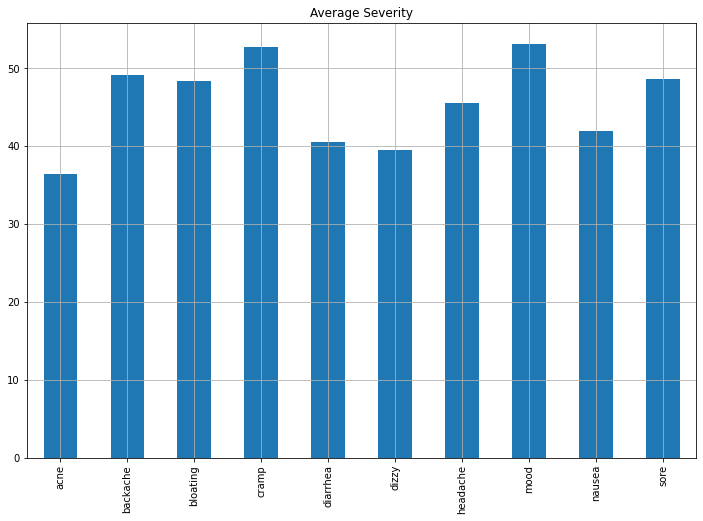

In [11]:
plt.rcParams["figure.figsize"] = (12, 8)
average_severity =  actual_df.sum()/yes_no_df.sum() 
average_severity.loc[ average_severity.index!= 'user_id', ].plot.bar(legend= False
                                                                     , title='Average Severity'
                                                                     ,grid = True)

- All symptoms seem equally severe, cramps and mood being slightly severe. Acne seems to be the least severe

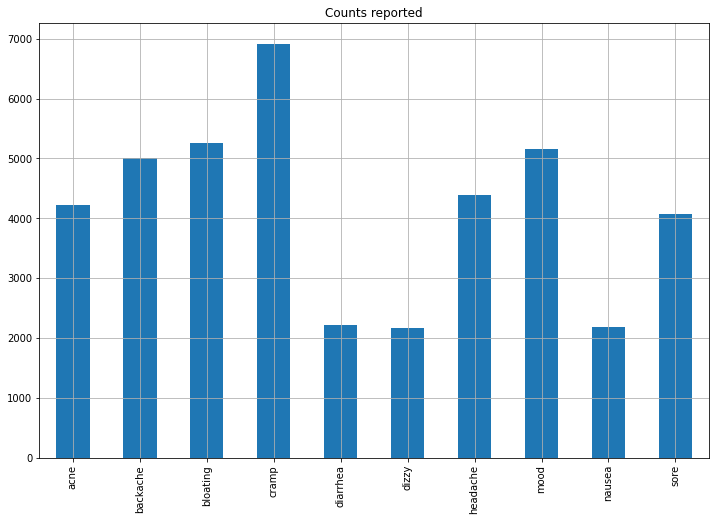

In [12]:
yn_sum = yes_no_df.sum()
yn_sum.loc[ yn_sum.index!= 'user_id', ].plot.bar(legend= False
                  , title='Counts reported'
                  ,grid = True)

Cramp is reported most followed by bloating and mood.

## Counts group by person.
- If a person reports cramp twice, it is counted as 1

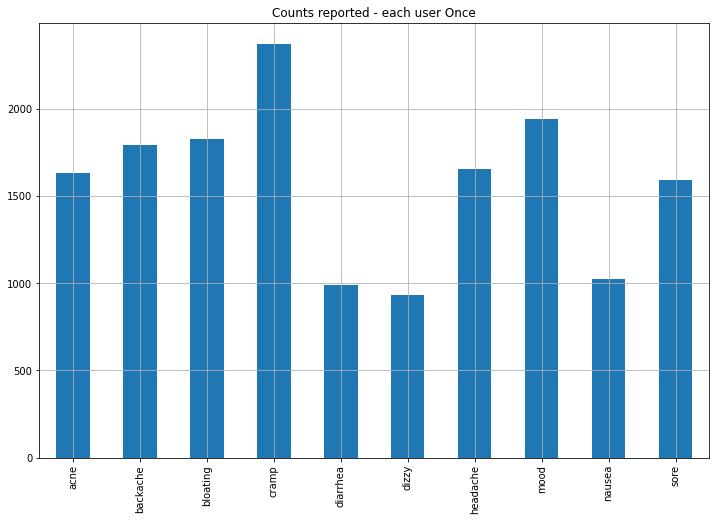

In [13]:
df_countOnce = yes_no_df.groupby( by = 'user_id').max()
coutOnce_sum = df_countOnce.sum()
coutOnce_sum.plot.bar(legend= False
                  , title='Counts reported - each user Once'
                  ,grid = True)

- We can say here that most people have cramp followed mood, bloating, backache, headache and sore.

## Co- Occurance matrix 

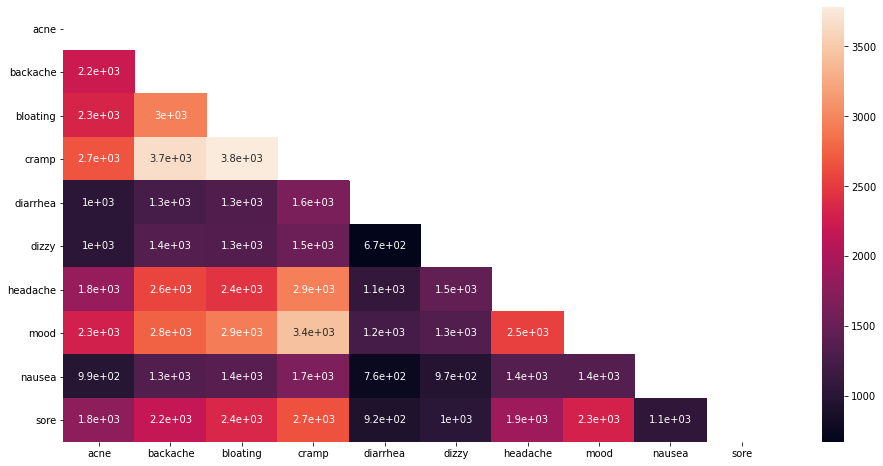

In [14]:
import seaborn as sns
plt.figure(figsize=(16,8))
df_asint = yes_no_df[[y for y in yes_no_df.columns if y not in ['user_id','date'] ] ].astype(int)
coocc = df_asint.T.dot(df_asint)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(coocc)

# using the upper triangle matrix as mask 
sns.heatmap(coocc, annot=True, mask=matrix)

- Backache, cramp and bloating co-occur the most.

## Correlation plot with severity
- Using the origin dataframe with severity as it makes sense to use the severity in a correlation plot.

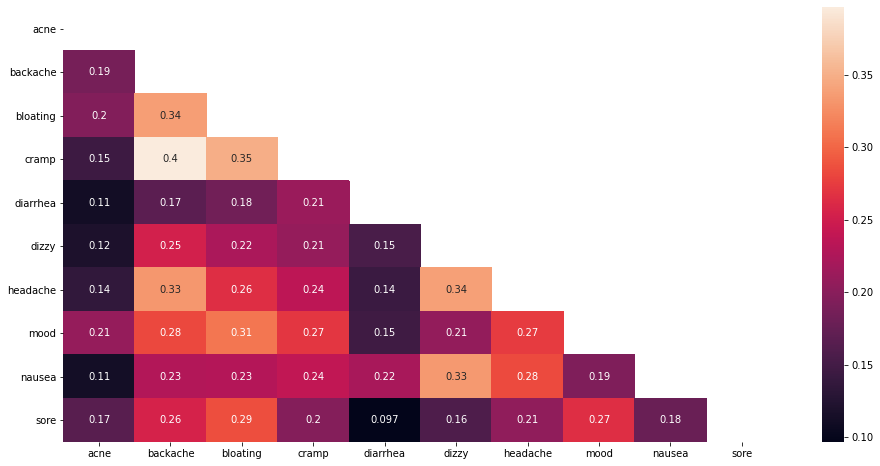

In [15]:
corr= actual_df[[y for y in yes_no_df.columns if y not in ['user_id','date'] ] ].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
plt.figure(figsize= (16,8) )
# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

- No strong correlations.
- Hypothesis test of Backache and Cramp , Dizzy and Nausea to see if they are the same. If so, treatments/medicines can be made which treats all related symptoms with a single type of pill.

## Hypothesis test between the symptoms
- Null hypothesis: They occur independant of each other during menstruation. Even though correlatin is not strong, we check if we can call them indepandant.

In [16]:
from scipy.stats import chi2_contingency

data_crosstab = pd.crosstab(yes_no_df['backache'].astype(int),
                            yes_no_df['cramp'].astype(int),
                               margins = False)

chi2, p, dof, expctd = chi2_contingency(data_crosstab, correction=False)

print('chi squared statistics: {} and p value : {}  '.format(chi2, p))
print('Degree of freedom {} '.format(dof))
print('\n')
print('Observed :')
print(data_crosstab)
print('Expected :')
print(expctd)

chi squared statistics: 1514.1323249566183 and p value : 0.0  
Degree of freedom 1 


Observed :
cramp        0     1
backache            
0         5197  3252
1         1345  3667
Expected :
[[4106.18512741 4342.81487259]
 [2435.81487259 2576.18512741]]


- Reject : Backache and Cramp are Dependant ( related to one another)
( Null hypothesis: Assumes that there is no association between the two variables)

## Least corelated 
- Diarrhoea and sore are tested for independance

In [17]:
data_crosstab = pd.crosstab(yes_no_df['sore'].astype(int),
                            yes_no_df['diarrhea'].astype(int),
                               margins = False)

chi2, p, dof, expctd = chi2_contingency(data_crosstab, correction=False)

print('chi squared statistics: {} and p value : {}  '.format(chi2, p))
print('Degree of freedom {} '.format(dof))
print('\n')
print('Observed :')
print(data_crosstab)
print('Expected :')
print(expctd)

chi squared statistics: 162.3905857446655 and p value : 3.399050192307854e-37  
Degree of freedom 1 


Observed :
diarrhea     0     1
sore                
0         8089  1298
1         3149   925
Expected :
[[7836.79563183 1550.20436817]
 [3401.20436817  672.79563183]]


- All symptoms are Dependant on each other according to the dataset. We could run the function inside a loop to find 2 way Chi Square tests for all.

In [18]:
chi_columns = [y for y in yes_no_df.columns if y not in ['user_id','date'] ]
for c1 in chi_columns:
  for c2 in chi_columns:
    data_crosstab = pd.crosstab(yes_no_df[c1].astype(int),
                            yes_no_df[c2].astype(int),
                               margins = False)

    chi2, p, dof, expctd = chi2_contingency(data_crosstab, correction=False)
    if p > 0.01:
      print('Independant Symptoms found')

## Explanation to Grandma:
- Cramp and mood changes are the most severe symptoms during menstruation, followed by backache, sore and bloating.
- Most reported symptoms were Cramp, followed my bloating and mood changes.
- Also, cramp, backache and bloating occur together the most.
- The severity of any of the symptoms are not strongly correlated. One cannot be used to linearly predict the other.
- No symptoms are independant of other symptoms. The occurance or absence of one may be dependant on ( can be affected by) others.